In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')

In [2]:
def datapreparation(filepath):
    
    df = pd.read_csv(filepath)
    df.drop(["customerID"], inplace = True, axis = 1)
    
    df.TotalCharges = df.TotalCharges.replace(" ",np.nan)
    df.TotalCharges.fillna(0, inplace = True)
    df.TotalCharges = df.TotalCharges.astype(float)
    
    cols1 = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    for col in cols1:
        df[col] = df[col].apply(lambda x: 0 if x == "No" else 1)
   
    df.gender = df.gender.apply(lambda x: 0 if x == "Male" else 1)
    df.MultipleLines = df.MultipleLines.map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    cols2 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in cols2:
        df[col] = df[col].map({'No internet service': 0, 'No': 0, 'Yes': 1})
    
    df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True,dtype=int)
    
    return df

In [3]:
df = datapreparation('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

C:\Users\sayan\AppData\Local\Temp\ipykernel_1652\4181834392.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.TotalCharges.fillna(0, inplace = True)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,...,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,...,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,...,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,...,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,...,70.70,151.65,1,1,0,0,0,0,1,0


In [4]:
df.isnull().any().any()

False

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier , VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
import warnings
warnings.filterwarnings("ignore") 

In [6]:
X = df.drop(columns='Churn')
y = df["Churn"]

In [7]:
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [8]:
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({0: 3892, 1: 1390})
After Counter({1: 3892, 0: 3892})


In [9]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)
    
    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")
        
        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)
            
        print("*"*30)
        print("\n")
        
        RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)
        
        return self.result_metrics
        
    def evaluate_metrics(self, y_pred_class):
        result_metrics = [] 
        accuracy = accuracy_score(self.y_test, y_pred_class)
        precision = precision_score(self.y_test, y_pred_class)
        recall = recall_score(self.y_test, y_pred_class)
        f1score = f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = roc_auc_score(self.y_test, y_pred_prob)
        
        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")
        
        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics
        
    def confusion_matrix(self, y_pred_class):
        cm = confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(cm,[0,1])
        
        
    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")
 
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
 
        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()
        
    def classification_report(self, y_pred_class):
        print(classification_report(self.y_test, y_pred_class))
               



******************************
Accuracy is : 77.3%
Precision is : 58.4%
Recall is : 57.6%
F1 Score is : 58.0%
Roc-Auc Score is:82.6%
******************************


              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1282
           1       0.58      0.58      0.58       479

    accuracy                           0.77      1761
   macro avg       0.71      0.71      0.71      1761
weighted avg       0.77      0.77      0.77      1761

******************************




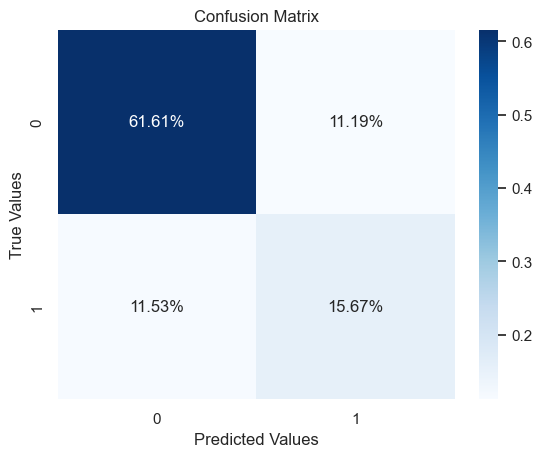

******************************




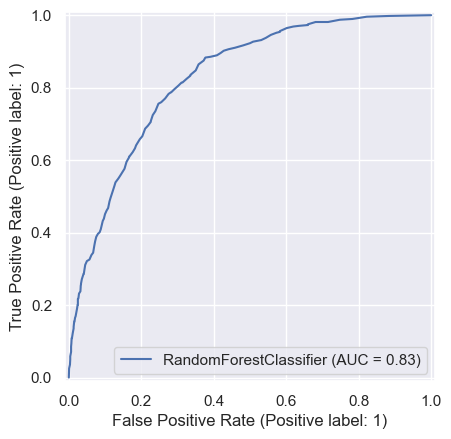

In [10]:
rf = RandomForestClassifier( random_state=42, criterion="gini" ,)
rf_modebuilder = ModelBuilder(rf, X_train, X_test, y_train, y_test)
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3892, number of negative: 3892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 7784, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


******************************
Accuracy is : 77.1%
Precision is : 57.6%
Recall is : 59.5%
F1 Score is : 58.5%
Roc-Auc Score is:83.7%
******************************


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1282
           1       0.58      0.59      0.59       479

    accuracy                           0.77      1761
   macro avg       0.71      0.72  

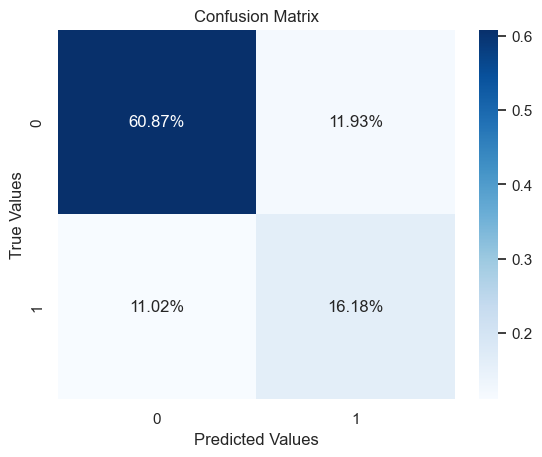

******************************




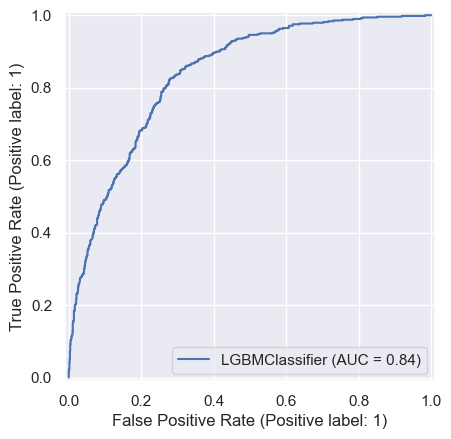

In [11]:
lgbm = LGBMClassifier()
lgbm_modebuilder = ModelBuilder(lgbm, X_train, X_test, y_train, y_test)
y_pred_class  = lgbm_modebuilder.train_model()
lgbm_metrics = lgbm_modebuilder.evaluate_model(y_pred_class)



******************************
Accuracy is : 77.4%
Precision is : 58.4%
Recall is : 59.1%
F1 Score is : 58.7%
Roc-Auc Score is:82.1%
******************************


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1282
           1       0.58      0.59      0.59       479

    accuracy                           0.77      1761
   macro avg       0.71      0.72      0.72      1761
weighted avg       0.77      0.77      0.77      1761

******************************




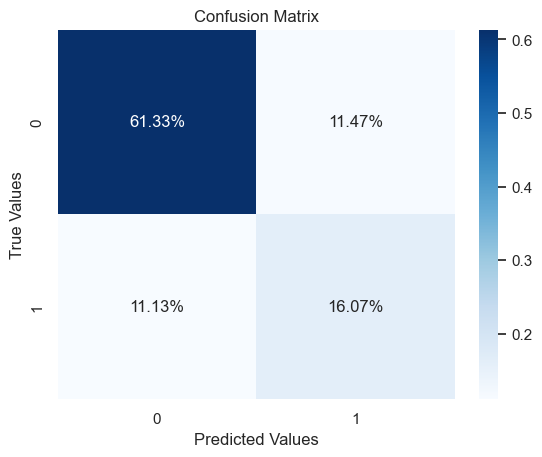

******************************




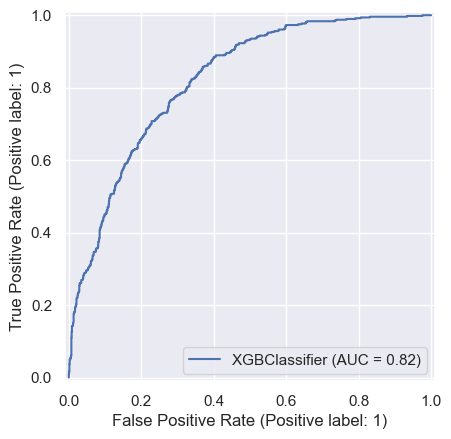

In [12]:
xg = XGBClassifier()
xgb_modebuilder = ModelBuilder(xg, X_train, X_test, y_train, y_test)
y_pred_class  = xgb_modebuilder.train_model()
xgb_metrics = xgb_modebuilder.evaluate_model(y_pred_class)

In [13]:
# LETS TRY OPTUNA to get the best model with hyperparameters (above we used gridsearch and default params)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [14]:
def objective(trial):
        model_name = trial.suggest_categorical("model",["SVC","RF","KNN","GB","XGB","LGBM"])

        if model_name == "SVC":
            kernel_svm = trial.suggest_categorical("kernel_svc",["linear","poly","rbf"])
            if kernel_svm == "linear":
                c_linear = trial.suggest_float("c_linear",0,5)
                model = SVC(C=c_linear,kernel="linear")

            elif kernel_svm == "poly":
                c_poly = trial.suggest_float("c_poly",0,10)
                degree_poly = trial.suggest_int("degree_poly",1,3)
                model = SVC(C=c_poly,degree=degree_poly,
                            kernel="poly")

            else:
                c_rbf = trial.suggest_float("c_rbf",0,100)
                gamma_rbf = trial.suggest_float("gamma_rbf",0,3)
                model = SVC(C=c_rbf,gamma=gamma_rbf,
                            kernel="rbf")
                

        elif model_name == "RF":
            n_estimators_rf = trial.suggest_int("n_estimators_rf",10,100)
            max_depth_rf = trial.suggest_int("max_depth_rf",2,10)
            model = RandomForestClassifier(n_estimators=n_estimators_rf,
                                        max_depth=max_depth_rf,
                                        random_state=42,
                                        n_jobs=-1)

        elif model_name == "GB":
            n_estimators_gb = trial.suggest_int("n_estimators_gb",10,100)
            learning_rate_gb = trial.suggest_float("learning_rate_gb",0,1)
            max_depth_gb = trial.suggest_int("max_depth_gb",2,20)
            model = GradientBoostingClassifier(n_estimators=n_estimators_gb,
                                                learning_rate=learning_rate_gb,
                                                max_depth=max_depth_gb,
                                                random_state=42)

        elif model_name == "KNN":
            n_neighbors_knn = trial.suggest_int("n_neighbors_knn",1,20)
            weights_knn = trial.suggest_categorical("weights_knn",["uniform","distance"])
            model = KNeighborsClassifier(n_neighbors=n_neighbors_knn,
                                        weights=weights_knn,n_jobs=-1)

        elif model_name == "XGB":
            n_estimators_xgb = trial.suggest_int("n_estimators_xgb",10,150)
            learning_rate_xgb = trial.suggest_float("learning_rate_xgb",0.1,0.5)
            max_depth_xgb = trial.suggest_int("max_depth_xgb",2,15)
            model = XGBClassifier(n_estimators=n_estimators_xgb,
                                    learning_rate=learning_rate_xgb,
                                    max_depth=max_depth_xgb,
                                    random_state=42,
                                    n_jobs=-1)

        elif model_name == "LGBM":
            n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm",10,200)
            learning_rate_lgbm = trial.suggest_float("learning_rate_lgbm",0.1,0.5)
            max_depth_lgbm = trial.suggest_int("max_depth_lgbm",2,20)
            model = LGBMClassifier(n_estimators=n_estimators_lgbm,
                                    learning_rate=learning_rate_lgbm,
                                    max_depth=max_depth_lgbm,
                                    random_state=42,n_jobs=-1)


        # train the model
        model.fit(X_train,y_train)


        # get the predictions
        y_pred_train = model.predict(X_train)
        y_pred_test= model.predict(X_test)

        # calculate the error
        score = accuracy_score(y_test,y_pred_test)

        return score

In [15]:
study = optuna.create_study(direction="maximize",study_name="model_selection")

# optimize the objective function
study.optimize(objective,n_trials=30,n_jobs=-1)

[I 2025-07-09 18:03:29,746] A new study created in memory with name: model_selection
[I 2025-07-09 18:03:31,083] Trial 2 finished with value: 0.7677455990914254 and parameters: {'model': 'XGB', 'n_estimators_xgb': 22, 'learning_rate_xgb': 0.3807770244090003, 'max_depth_xgb': 11}. Best is trial 2 with value: 0.7677455990914254.
[I 2025-07-09 18:03:31,176] Trial 3 finished with value: 0.7705848949460534 and parameters: {'model': 'XGB', 'n_estimators_xgb': 27, 'learning_rate_xgb': 0.20345745463292397, 'max_depth_xgb': 9}. Best is trial 3 with value: 0.7705848949460534.
[I 2025-07-09 18:03:31,330] Trial 1 finished with value: 0.7853492333901193 and parameters: {'model': 'XGB', 'n_estimators_xgb': 50, 'learning_rate_xgb': 0.47483986570730286, 'max_depth_xgb': 3}. Best is trial 1 with value: 0.7853492333901193.
[I 2025-07-09 18:03:31,939] Trial 8 finished with value: 0.7654741624077229 and parameters: {'model': 'XGB', 'n_estimators_xgb': 10, 'learning_rate_xgb': 0.40376200410981344, 'max_dep

In [16]:
study.best_value

0.7853492333901193

In [25]:
study.best_params

{'model': 'XGB',
 'n_estimators_xgb': 50,
 'learning_rate_xgb': 0.47483986570730286,
 'max_depth_xgb': 3}

In [17]:
sc = StackingClassifier(estimators=[('xgb',xg),('rf',rf)],final_estimator=lgbm,cv=5)

[LightGBM] [Info] Number of positive: 3892, number of negative: 3892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 7784, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


******************************
Accuracy is : 77.9%
Precision is : 60.3%
Recall is : 54.9%
F1 Score is : 57.5%
Roc-Auc Score is:82.1%
******************************


              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1282
           1       0.60      0.55      0.57       479

    accuracy                           0.78      1761
   macro avg       0.72      0.71      0.71      1761
weighted avg       0.77      0.78      0.78      1761

******************************




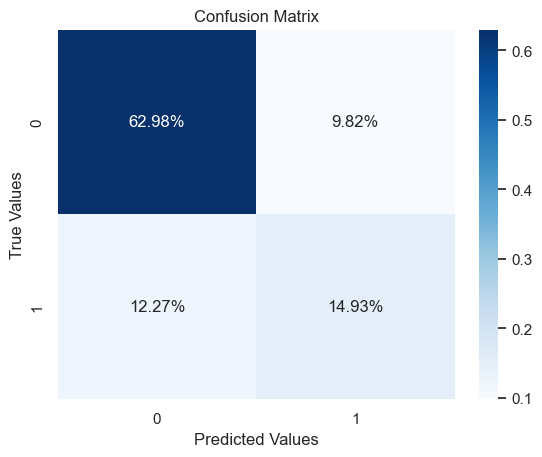

******************************




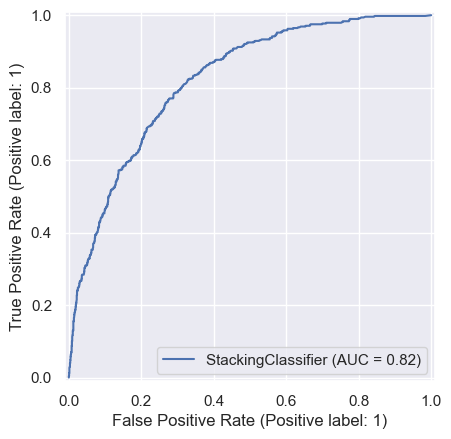

In [18]:
sc_modebuilder = ModelBuilder(sc, X_train, X_test, y_train, y_test)
y_pred_class  = sc_modebuilder.train_model()
sc_metrics = sc_modebuilder.evaluate_model(y_pred_class)

In [19]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs = SFS(rf,k_features='best',forward=True,floating=False,n_jobs=-1,cv=5)
sfs.fit(X_train,y_train)
metric_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
metric_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[0.6730892742453436, 0.6647398843930635, 0.674...",0.675489,"(tenure,)",0.008682,0.006755,0.003377
2,"(4, 15)","[0.72703917790623, 0.7193320488118176, 0.76300...",0.749874,"(tenure, TotalCharges)",0.02839,0.022088,0.011044
3,"(4, 14, 15)","[0.7533718689788054, 0.7495183044315993, 0.791...",0.779808,"(tenure, MonthlyCharges, TotalCharges)",0.030194,0.023492,0.011746
4,"(4, 14, 15, 18)","[0.7578676942838792, 0.7546563904945408, 0.818...",0.792783,"(tenure, MonthlyCharges, TotalCharges, Contrac...",0.038402,0.029878,0.014939
5,"(4, 7, 14, 15, 18)","[0.7527296082209377, 0.7591522157996147, 0.835...",0.803576,"(tenure, OnlineSecurity, MonthlyCharges, Total...",0.050074,0.038959,0.01948
6,"(4, 7, 14, 15, 18, 19)","[0.7662170841361593, 0.7623635195889531, 0.834...",0.810899,"(tenure, OnlineSecurity, MonthlyCharges, Total...",0.049456,0.038478,0.019239
7,"(4, 5, 7, 14, 15, 18, 19)","[0.7617212588310854, 0.7649325626204239, 0.850...",0.816552,"(tenure, PhoneService, OnlineSecurity, Monthly...",0.055977,0.043552,0.021776
8,"(4, 5, 7, 11, 14, 15, 18, 19)","[0.7565831727681439, 0.7662170841361593, 0.854...",0.819636,"(tenure, PhoneService, OnlineSecurity, Streami...",0.061332,0.047718,0.023859
9,"(4, 5, 7, 9, 11, 14, 15, 18, 19)","[0.7591522157996147, 0.7681438664097624, 0.863...",0.824132,"(tenure, PhoneService, OnlineSecurity, DeviceP...",0.063689,0.049552,0.024776
10,"(4, 5, 7, 9, 11, 14, 15, 18, 19, 20)","[0.75208734746307, 0.7694283879254977, 0.87090...",0.826316,"(tenure, PhoneService, OnlineSecurity, DeviceP...",0.069164,0.053812,0.026906


In [20]:
list(sfs.k_feature_idx_) # best features 

[2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 22]

In [21]:
X_train_sfs = X_train.iloc[:,list(sfs.k_feature_idx_)]
X_test_sfs = X_test.iloc[:,list(sfs.k_feature_idx_)]



******************************
Accuracy is : 77.6%
Precision is : 58.9%
Recall is : 57.8%
F1 Score is : 58.4%
Roc-Auc Score is:81.8%
******************************


              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1282
           1       0.59      0.58      0.58       479

    accuracy                           0.78      1761
   macro avg       0.72      0.71      0.72      1761
weighted avg       0.77      0.78      0.78      1761

******************************




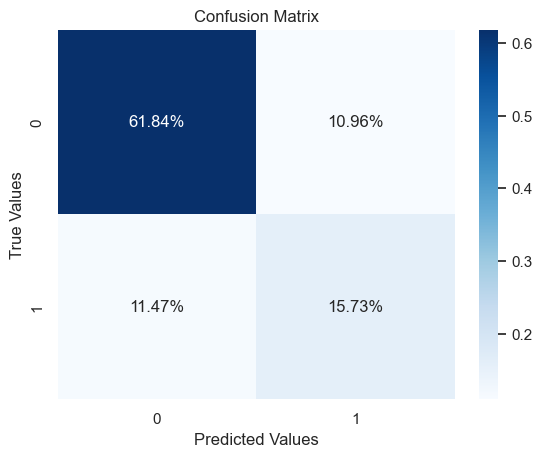

******************************




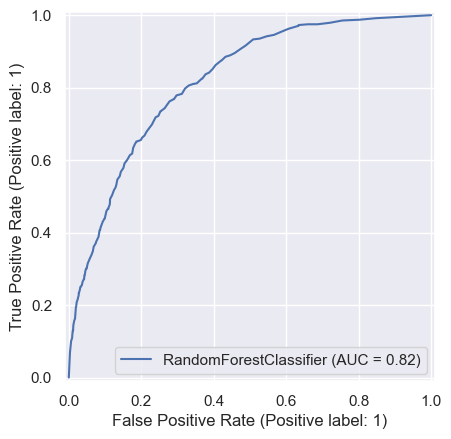

In [22]:
rf_modebuilder = ModelBuilder(rf, X_train_sfs, X_test_sfs, y_train, y_test)
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

In [23]:
from sklearn.model_selection import GridSearchCV
param_grid3 = {'max_features':['sqrt','log2'],
          'n_estimators':[950,1000,1050],
           'criterion': ['entropy'],    
          'max_depth': [10],
          'min_samples_leaf': [1, 3, 5, 7],
          'min_samples_split': [2, 4, 6, 8]
         }

grid3 = GridSearchCV(estimator=rf, param_grid=param_grid3, n_jobs=-1, cv=5, verbose=1, scoring = 'f1')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [10],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [950, 1000, 1050]},
             scoring='f1', verbose=1)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


******************************
Accuracy is : 77.5%
Precision is : 57.0%
Recall is : 70.1%
F1 Score is : 62.9%
Roc-Auc Score is:84.5%
******************************


              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1282
           1       0.57      0.70      0.63       479

    accuracy                           0.78      1761
   macro avg       0.72      0.75      0.73      1761
weighted avg       0.79      0.78      0.78      1761

******************************




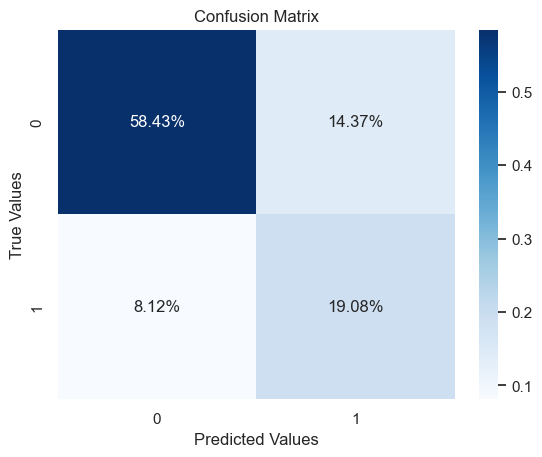

******************************




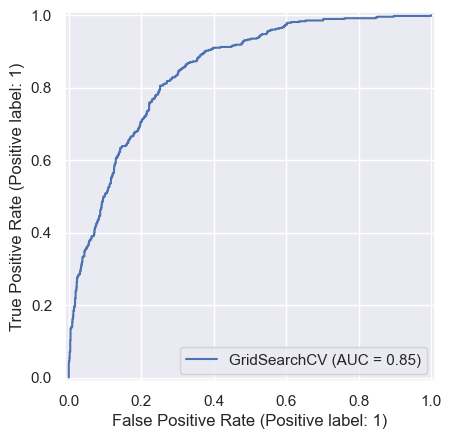

In [24]:
rf_best = ModelBuilder(grid3, X_train_sfs, X_test_sfs, y_train, y_test)
y_pred_class  = rf_best.train_model()
rf_best_metrics = rf_best.evaluate_model(y_pred_class)

In [26]:
param_xg = {
 'n_estimators': 50,
 'learning_rate': 0.47483986570730286,
 'max_depth': 3 }
xg_optuna = XGBClassifier(**param_xg)



******************************
Accuracy is : 78.6%
Precision is : 59.5%
Recall is : 66.6%
F1 Score is : 62.9%
Roc-Auc Score is:83.5%
******************************


              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1282
           1       0.60      0.67      0.63       479

    accuracy                           0.79      1761
   macro avg       0.73      0.75      0.74      1761
weighted avg       0.79      0.79      0.79      1761

******************************




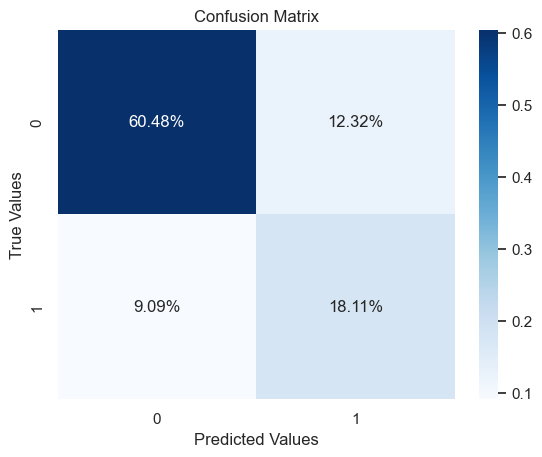

******************************




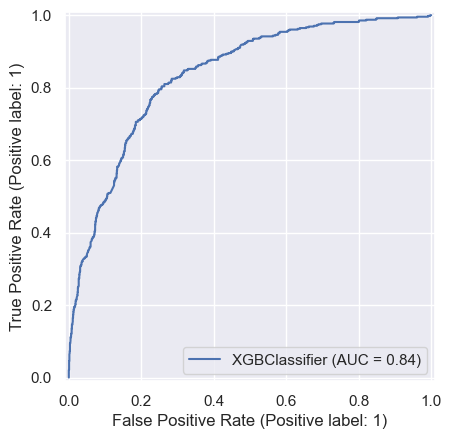

In [27]:
xg_opt = ModelBuilder(xg_optuna, X_train_sfs, X_test_sfs, y_train, y_test)
y_pred_class  = xg_opt.train_model()
xg_opt_best_metrics = xg_opt.evaluate_model(y_pred_class)

In [28]:
# XGBOOST gives accuracy of 78.6% with 67% recall

In [35]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))


In [37]:
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 8: Build Neural Network
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 9: Train the model
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[es],class_weight=class_weights,
                    verbose=1)

# Step 10: Predict and evaluate
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5938 - loss: 0.6945 - val_accuracy: 0.8176 - val_loss: 0.4978
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7794 - loss: 0.4626 - val_accuracy: 0.8805 - val_loss: 0.3809
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7821 - loss: 0.4581 - val_accuracy: 0.8671 - val_loss: 0.3509
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7931 - loss: 0.4333 - val_accuracy: 0.8953 - val_loss: 0.2935
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7914 - loss: 0.4303 - val_accuracy: 0.8838 - val_loss: 0.3029
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7873 - loss: 0.4352 - val_accuracy: 0.8927 - val_loss: 0.2832
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7971 - loss: 0.4262 - val_accuracy: 0.8850 - val_loss: 0.3019
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7969 - loss: 0.4123 - val_accuracy: 0.8863 - v

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8305 - loss: 0.3590 - val_accuracy: 0.9467 - val_loss: 0.1378
Epoch 52/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8307 - loss: 0.3540 - val_accuracy: 0.9557 - val_loss: 0.1507
Epoch 53/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.3618 - val_accuracy: 0.9428 - val_loss: 0.1484
Epoch 54/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8226 - loss: 0.3687 - val_accuracy: 0.9461 - val_loss: 0.1527
Epoch 55/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8305 - loss: 0.3606 - val_accuracy: 0.9409 - val_loss: 0.1536
Epoch 56/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8343 - loss: 0.3476 - val_accuracy: 0.9570 - val_loss: 0.1298
Epoch 57/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8358 - loss: 0.3497 - val_accuracy: 0.9461 - val_loss: 0.1667
Epoch 58/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8341 - loss: 0.3466 - val_accuracy: 0.9499 - val_lo